In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys, glob, copy, os

from utils.plotting.plotting_utils import figSize
from utils.simulation.simulation import simulateBCIFitts
from utils.simulation import simulation_utils
from utils.preprocessing import sweep_utils

from utils.recalibration import RTI_utils, stabilizer_utils, hmm_utils, hmm
from stabilizer_utils import Stabilizer
from hmm import HMMRecalibration
from RTI_utils import RTI

from joblib import Parallel, delayed
import copy

from sklearn.linear_model import LinearRegression

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def testStabilizer(base_opts, ss_opts, n_days, n_reps):
    
    scores_dict = copy.deepcopy(ss_opts)
    scores      = np.zeros((n_reps))
    
    for i in range(n_reps):
        cfg, ss_decoder_dict, stabilizer = simulation_utils.initializeBCI({**base_opts, **ss_opts})
        cfg['neuralTuning'][:, 0] = 0
        
        scores_dict['reference_cfg'] = copy.deepcopy(cfg)

        for j in range(n_days):
            cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = base_opts['n_stable'], PD_shrinkage = base_opts['shrinkage'], 
                                                                          mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
            cfg['D']    = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg, ss_decoder_dict, stabilizer, ss_opts, daisy_chain = ss_opts['chained'])
            cfg['beta'] = simulation_utils.gainSweep(cfg, possibleGain = base_opts['possibleGain'])
            
        scores[i]   = np.mean(simulateBCIFitts(cfg)['ttt'])
        
    scores_dict['ttt'] = scores
    scores_dict['final_cfg']  = copy.deepcopy(cfg)
    scores_dict['stabilizer'] = stabilizer

    return scores_dict

In [11]:
# for a reproducible result
np.random.seed(1)


##############################
ss_sweep_opts  = dict()  # stabilizer sweep settings

ss_sweep_opts['thresh']       = [0.05]
ss_sweep_opts['n_components'] = [2]
ss_sweep_opts['B']            = [100]
ss_sweep_opts['chained']      = [True]

base_opts      = dict()  # unchanging parameters

base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 10000
base_opts['nUnits']         = 192
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = True
base_opts['nTrainingSteps'] = 10000
base_opts['shrinkage']      = 0.91
base_opts['n_stable']       = 0


base_opts['model_type']    = 'PCA'


nReps = 30
nDays = 30

##############################


In [12]:
#--------------------------------------------------
if __name__ == '__main__':

    ss_args    = sweep_utils.generateArgs(ss_sweep_opts, {})
    sweep_args = ss_args

    print('Stabilizer: {} parameters to sweep'.format(len(ss_args)))
    print('Number for this job: ', len(sweep_args))
    
    sweep_scores = Parallel(n_jobs= -1, verbose = 5)(delayed(testStabilizer)(base_opts, x, nDays, nReps) for x in sweep_args)
    np.save(os.path.join(args.saveDir,  'sweep_scores_{}.npy'.format(args.jobID)), sweep_scores)
    print('Finished.')

Stabilizer: 1 parameters to sweep
Number for this job:  1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:233: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:236: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)


KeyboardInterrupt: 

TODO:
    - create a testStabilizer() fcn for below
    - add HP sweep over B, threshold parameter

In [ ]:
from utils.recalibration.stabilizer_utils import Stabilizer


np.random.seed(42)

# Now introduce encoding shift via channel permutation and measure performance across strengths

B = 150
asym_levels = [0, 1, 2, 3]
reps        = 100 # reps per condition

dicts = list()
n_stable = encoding.shape[0] - n_permuted
print(f'{n_permuted}-channel alteration...')
for _ in range(reps):
    for i, asym_level in enumerate(asym_levels):

        # Generate asymmetric matrix:
        asym_encoding = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
        neural_asym, kinematic_asym = simulateUnitActivity(asym_encoding, noise=noise, nSteps=10000)   

        # Train decoder in FA latent space:
        stabilizer  = Stabilizer(n_components=2, model_type='FactorAnalysis').fit_ref([neural_asym])
        latent_asym = stabilizer.ref_model.transform(neural_asym) 

        decoder = LinearRegression().fit(latent_asym, kinematic_asym)
        r2_orig = decoder.score(latent_asym, kinematic_asym)

        # Create new tuning
        enc_altered = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
        enc_altered[:10, :] = asym_encoding[:10, :]
        neural_asym, kinematic_asym = simulateUnitActivity(enc_altered, noise=noise, nSteps=10000)

        # test old model on new data
        latents_asym = stabilizer.ref_model.transform(neural_asym)
        r2_drift     = decoder.score(latents_asym, kinematic_asym)
        preds_drift  = decoder.predict(latents_asym)
        corr_drift   = np.corrcoef(preds_drift.flatten(), kinematic_asym.flatten())[0, 1]

        # Test latent space decoder after applying FA stabilizer:
        stabilizer.fit_new([neural_asym], B=B, thresh=0.)
        neural_realigned = stabilizer.transform(neural_asym)
        r2_realigned     = decoder.score(neural_realigned, kinematic_asym)
        preds            = decoder.predict(neural_realigned)

        subspace_corr = np.corrcoef(enc_altered[:, 1:].flatten(), asym_encoding[:, 1:].flatten())[0,1]

        x_corr = np.corrcoef(preds.T, kinematic_asym.T)[0, 2]
        y_corr = np.corrcoef(preds.T, kinematic_asym.T)[1, 3]
        corr_realigned = np.corrcoef(preds.flatten(), kinematic_asym.flatten())[0,1]

        #upper bound from a subspace decoder trained on new neural data:
        #latents    = stabilizer.new_model.transform(neural_asym)
        best_preds = LinearRegression().fit(neural_asym, kinematic_asym).predict(neural_asym)
        x_best     = np.corrcoef(best_preds.T, kinematic_asym.T)[0, 2]
        y_best     = np.corrcoef(best_preds.T, kinematic_asym.T)[1, 3]

        example_dict = {
            'n_stable'    : B,
            'subspace_correlation' : subspace_corr,
            'asym_level'  : asym_level,
            'r2_orig'     : r2_orig,
            'r2_drift'    : r2_drift,
            'corr_drift'  : corr_drift,
            'r2_realigned': r2_realigned,
            'corr_realigned' : corr_realigned,
            'x_corr' : x_corr,
            'y_corr' : y_corr,
            'x_corr_norm' : x_corr / x_best,
            'y_corr_norm' : y_corr / y_best

        }

        dicts.append(example_dict)


0-channel alteration...


In [534]:
from scipy.linalg import orthogonal_procrustes


asym_level=2

# Generate asymmetric matrix:
asym_encoding = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
neural_asym, kinematic_asym = simulateUnitActivity(asym_encoding, noise=noise, nSteps=10000)   

# Train decoder in FA latent space:
stabilizer  = Stabilizer(n_components=2, model_type='FactorAnalysis').fit_ref([neural_asym])
latent_asym = stabilizer.ref_model.transform(neural_asym) 

# Create new tuning
enc_altered = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
neural_asym, kinematic_asym = simulateUnitActivity(enc_altered, noise=noise, nSteps=10000)

# Test latent space decoder after applying FA stabilizer:
stabilizer.fit_new([neural_asym], B=100, thresh=0.)

R, _ = orthogonal_procrustes(stabilizer.new_coefs[stabilizer.good_chans, :], 
                      stabilizer.ref_coefs[stabilizer.good_chans, :])
stabilizer.R = R

In [535]:
np.linalg.norm(stabilizer.ref_coefs - stabilizer.new_coefs.dot(stabilizer.R))

0.7306536080420536

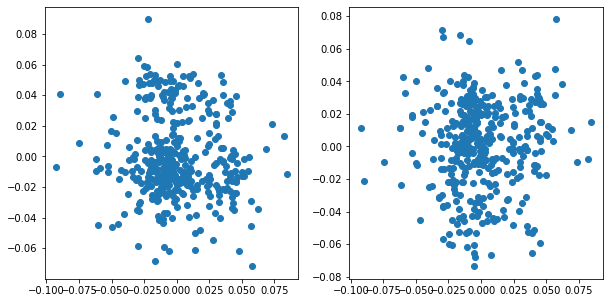

In [549]:
np.linalg.norm(stabilizer.ref_coefs - stabilizer.new_coefs.dot(stabilizer.R), axis=1).mean()

figSize(5,10)
plt.subplot(121)
plt.scatter(stabilizer.ref_coefs.flatten(), stabilizer.new_coefs.flatten())

plt.subplot(122)
plt.scatter(stabilizer.ref_coefs.flatten(), stabilizer.new_coefs.dot(stabilizer.R).flatten())

In [541]:
np.linalg.norm(stabilizer.ref_coefs - stabilizer.new_coefs, axis=1).mean()

0.04977438100931286

Text(0.5, 1.0, 'Rotated and orig')

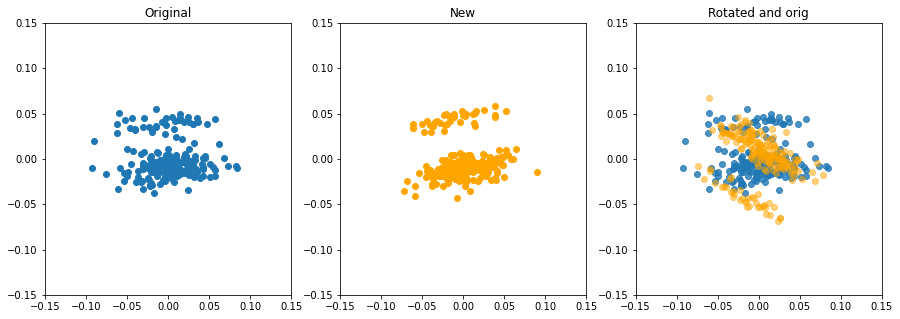

In [545]:
figSize(5, 15)
plt.subplot(1,3,1)
plt.scatter(stabilizer.ref_coefs[:, 0], stabilizer.ref_coefs[:, 1])
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('Original')

plt.subplot(1,3,2)
plt.scatter(stabilizer.new_coefs[:, 0], stabilizer.new_coefs[:, 1], color='orange')
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('New')

plt.subplot(1,3,3)
rotated = stabilizer.new_coefs.dot(stabilizer.R)
plt.scatter(stabilizer.ref_coefs[:, 0], stabilizer.ref_coefs[:, 1],alpha=0.8)
plt.scatter(rotated[:, 0], rotated[:, 1],color='orange',alpha=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('Rotated and orig')

-------Subspace correlation tests------
RanksumsResult(statistic=-0.1123958888078008, pvalue=0.9105095149301567)
RanksumsResult(statistic=1.4587031656142844, pvalue=0.14464682444369945)
RanksumsResult(statistic=1.4611465545014104, pvalue=0.14397522649347136)
RanksumsResult(statistic=0.561979444039004, pvalue=0.5741300245156267)
RanksumsResult(statistic=0.6157339995557783, pvalue=0.538070093783497)
RanksumsResult(statistic=-0.7794410549932274, pvalue=0.43571994753686616)

 -------post-drift decoder output correlations test------
RanksumsResult(statistic=0.42514966635994217, pvalue=0.6707275738679133)
RanksumsResult(statistic=1.9033999430712354, pvalue=0.0569883784571484)
RanksumsResult(statistic=1.0237799437058377, pvalue=0.30593922560393827)
RanksumsResult(statistic=1.3463072768064834, pvalue=0.1782034400273047)
RanksumsResult(statistic=0.3860554441659245, pvalue=0.6994556070793274)
RanksumsResult(statistic=-0.6474980550884176, pvalue=0.5173096528574608)


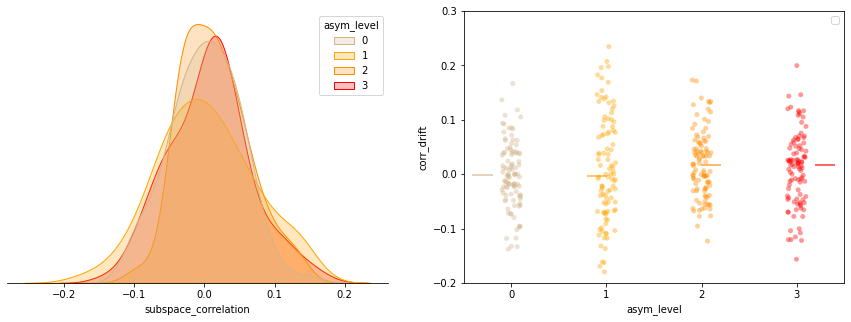

In [531]:
import pandas as pd, seaborn as sns

colors = ['tan', 'orange', 'darkorange', 'red']

figSize(5, 15)

df = pd.DataFrame(dicts)

plt.subplot(1,2,1)
sns.kdeplot(df, x='subspace_correlation',  hue='asym_level', palette=colors, fill=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel(None)

plt.subplot(1,2,2)
ax = plt.gca()
sns.stripplot(df, x='asym_level', y='corr_drift', hue='asym_level', palette = colors,
              alpha = 0.4, ax = ax)

sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=df, x ='asym_level', y = 'corr_drift', showfliers=False, showbox=False, 
            showcaps=False, hue = 'asym_level', palette = colors, ax = ax)

for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[np.floor(i/3).astype(int)])

plt.legend([])
plt.ylim([-0.2, 0.3])


# now run stats on group differences:
print('-------Subspace correlation tests------')
for i in np.unique(df.asym_level):
    for j in np.unique(df.asym_level):
        if i > j:
            stats = scipy.stats.ranksums(df[df.asym_level == i]['subspace_correlation'],
                                         df[df.asym_level == j]['subspace_correlation'])
            print(stats)

print('\n -------post-drift decoder output correlations test------')
for i in np.unique(df.asym_level):
    for j in np.unique(df.asym_level):
        if i > j:
            stats = scipy.stats.ranksums(df[df.asym_level == i]['corr_drift'],df[df.asym_level == j]['corr_drift'])
            print(stats)

(-1.2, 1.2)

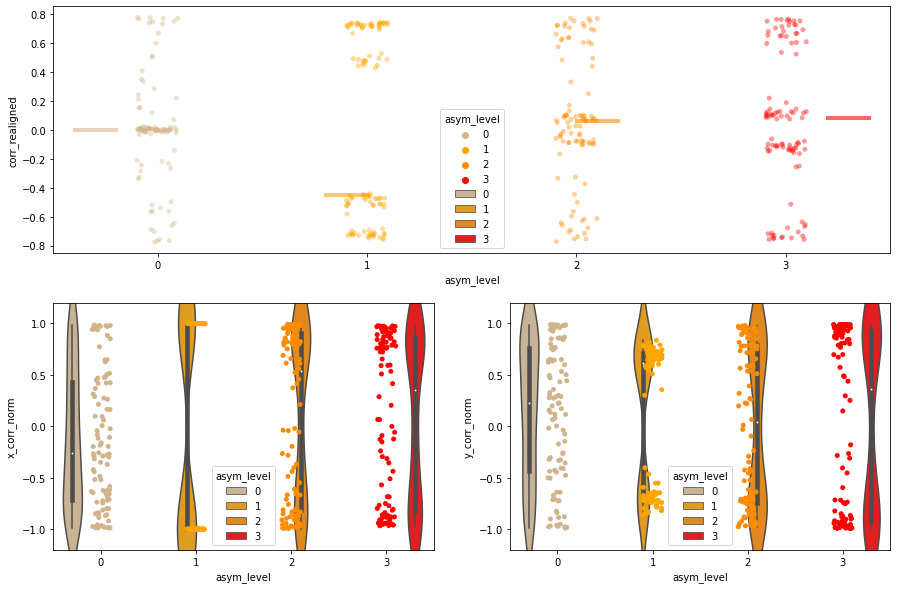

In [532]:
import pandas as pd, seaborn as sns


figSize(10, 15)

plt.subplot(2, 1, 1)
sns.stripplot(df, x='asym_level', y='corr_realigned', hue='asym_level', palette = colors,
              alpha = 0.4)

sns.boxplot(medianprops={'ls': '-', 'lw': 4, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=df, x ='asym_level', y = 'corr_realigned', showfliers=False, showbox=False, 
            showcaps=False, hue = 'asym_level', palette = colors)

for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[np.floor(i/3).astype(int)])

    


df = pd.DataFrame(dicts)


plt.subplot(2,2,3)
sns.violinplot(df, x='asym_level', y='x_corr_norm', hue='asym_level', palette = colors)
sns.stripplot(df, x='asym_level', y='x_corr_norm', hue='asym_level', palette = colors, legend=None)
plt.ylim([-1.2, 1.2])


plt.subplot(2,2,4)
sns.violinplot(df, x='asym_level', y='y_corr_norm', hue='asym_level', palette= colors)
sns.stripplot(df, x='asym_level', y='y_corr_norm', hue='asym_level', palette = colors, legend=None)

plt.ylim([-1.2, 1.2])

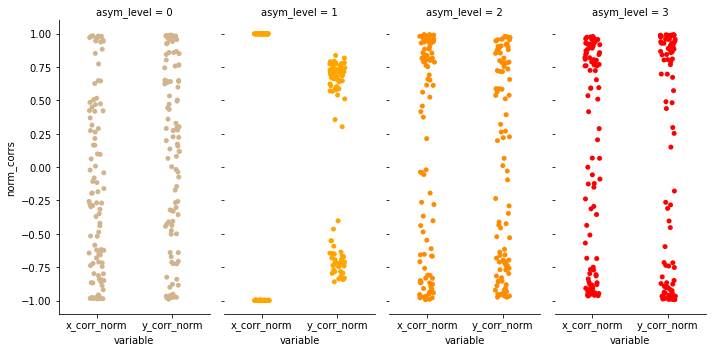

In [533]:
copy = df.copy()
copy = pd.melt(copy, id_vars = ['asym_level'], value_vars = ["x_corr_norm", "y_corr_norm"], value_name="norm_corrs")


#figSize(2, 2)
g = sns.catplot(data=copy, x="variable", y="norm_corrs", hue="asym_level", col="asym_level",
            palette = colors, aspect=.5)

for col_val, ax in g.axes_dict.items():
    if col_val > 0:
        ax.spines['left'].set_visible(False)

TypeError: makeEncodingAsymmetric() got an unexpected keyword argument 'encoding'

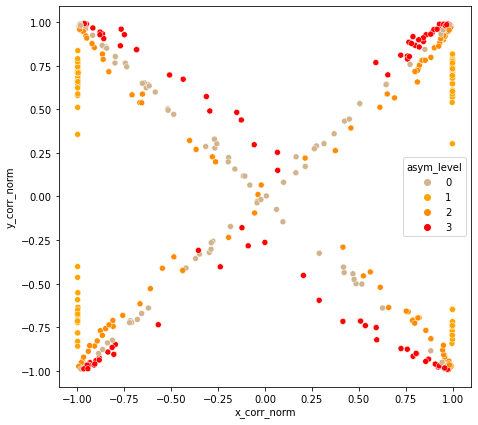

In [530]:
figSize(7, 10)


n_encodings = len(np.unique(df.asym_level)) 

lims = [-0.15, 0.15]

fig = plt.figure()

gs = fig.add_gridspec(n_encodings,n_encodings)
ax = fig.add_subplot(gs[:n_encodings, 1:])

sns.scatterplot(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', ax = ax, palette = colors)
#sns.jointplot(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', ax = ax, palette = colors)

#g = sns.JointGrid(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', palette = colors)
#g.plot(sns.scatterplot, sns.histplot, ax = ax,)

for i in range(n_encodings):
    encoding       = generateUnits(n_units=n_units, SNR= SNR)
    encoding[:, 0] = 0
    asym_encoding  = makeEncodingAsymmetric(encoding=encoding, strength=i)

    # plot side-by-side to demonstrate channel tuning asymmetry
    #plt.subplot(3,3,(i+1)*3)
    ax = fig.add_subplot(gs[i, 0])
    ax.scatter(asym_encoding[:, 1], asym_encoding[:, 2], alpha=0.6, c = colors[i])
    #plt.xlim(lims)
    #plt.ylim(lims)
    #ax.set_xticks(plt.xlim())
    #ax.set_yticks(plt.ylim())
    plt.title(f'Tuning coefficient distribution (asym={i})')
    
plt.tight_layout()
plt.show()

Results:

- asym_level = 0: model is randomly rotating the subspace axes around, so on average it doesn't do too well. As x-readout gets more accurate, y-readout can either get better or worse (depending on rotation angle) because of rigid transformation.

- asym_level = 1: y-axis has smaller encoding so it gets messed up a lot. but when kk, there are 4 clusters (x/y parallel, x parallel/y antiparallel, x antiparallel/y parallel, x/y antiparallel)

- asym_level = 2: y-axis is correct always because of asym, x-readout can either be parallel or antiparallel with x-encoding weights. Subset of days where alignment just totally fails (near 0 for both). 